In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdmolops
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os


In [2]:
tox21_file = "data/tox21.csv"
data = pd.read_csv(tox21_file)

smiles_column = "SMILES"  
label_columns = ['SR-HSE','NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',\
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD'] 

data = data.dropna()

smiles_list = data[smiles_column]
labels = data[label_columns]





In [3]:

data.shape

(3123, 18)

In [4]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    adjacency_matrix = rdmolops.GetAdjacencyMatrix(mol)
    graph = nx.from_numpy_array(adjacency_matrix)
    for i, atom in enumerate(mol.GetAtoms()):
        graph.nodes[i]['atom_type'] = atom.GetSymbol()
    return graph

graphs = [smiles_to_graph(smiles) for smiles in smiles_list]

valid_data = [(graph, label) for graph, label in zip(graphs, labels.values) if graph is not None]
graphs, labels = zip(*valid_data)
labels = pd.DataFrame(labels) 



In [5]:
def generate_node_embeddings(graphs, dimensions=64, walk_length=10, num_walks=50):
    embeddings = []
    for graph in tqdm(graphs):
        node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=1, quiet = True)
        model = node2vec.fit()
        node_embeddings = [model.wv[str(node)] for node in graph.nodes]
        molecule_embedding = sum(node_embeddings) / len(node_embeddings)
        embeddings.append(molecule_embedding)
    return embeddings

if not os.path.exists("embeddings.pickle"):
    embeddings = generate_node_embeddings(graphs)
else:
    embeddings = pd.read_pickle("embeddings.pickle")




100%|██████████| 3123/3123 [01:04<00:00, 48.45it/s]


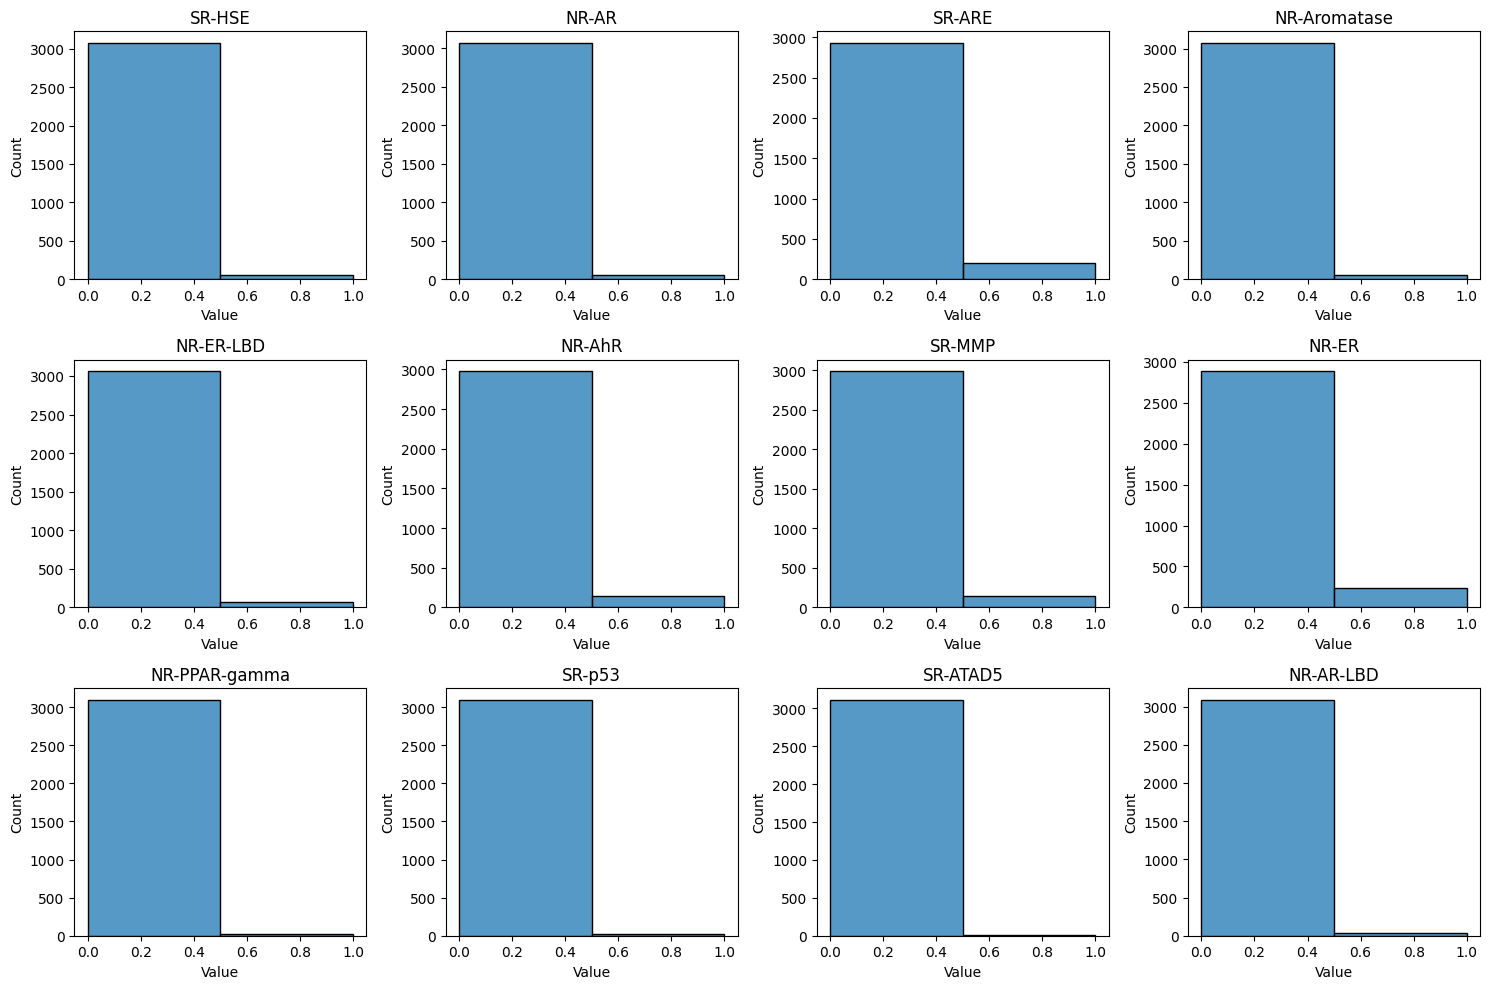

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for i, label in enumerate(label_columns):
    sns.histplot(labels[i].dropna(), bins=2, kde=False, ax=axes[i])
    axes[i].set_title(label)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

#train_null_mask = np.array(np.logical_not(y_train.isnull().values), dtype=int)
#test_null_mask = np.array(np.logical_not(y_test.isnull().values), dtype=int)

#y_train = y_train.fillna(0)
#y_test = y_test.fillna(0)

#mask_df = pd.DataFrame(null_mask, columns= [col + '_mask' for col in raw_y.columns], index = raw_y.index)

#raw_y = pd.concat([raw_y, mask_df], axis=1)



In [26]:
#y_train, train_null_mask


AttributeError: 'DataFrame' object has no attribute 'counts'

In [9]:
#y_train = pd.DataFrame(train_null_mask, columns = [i for i in range(train_null_mask.shape[1])])
#y_test = pd.DataFrame(test_null_mask, columns = [i for i in range(test_null_mask.shape[1])])

 50%|█████     | 3/6 [00:13<00:10,  3.50s/it]

[LightGBM] [Info] Number of positive: 38, number of negative: 2460
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 2498, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015212 -> initscore=-4.170330
[LightGBM] [Info] Start training from score -4.170330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 43, number of negative

 67%|██████▋   | 4/6 [00:15<00:05,  2.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


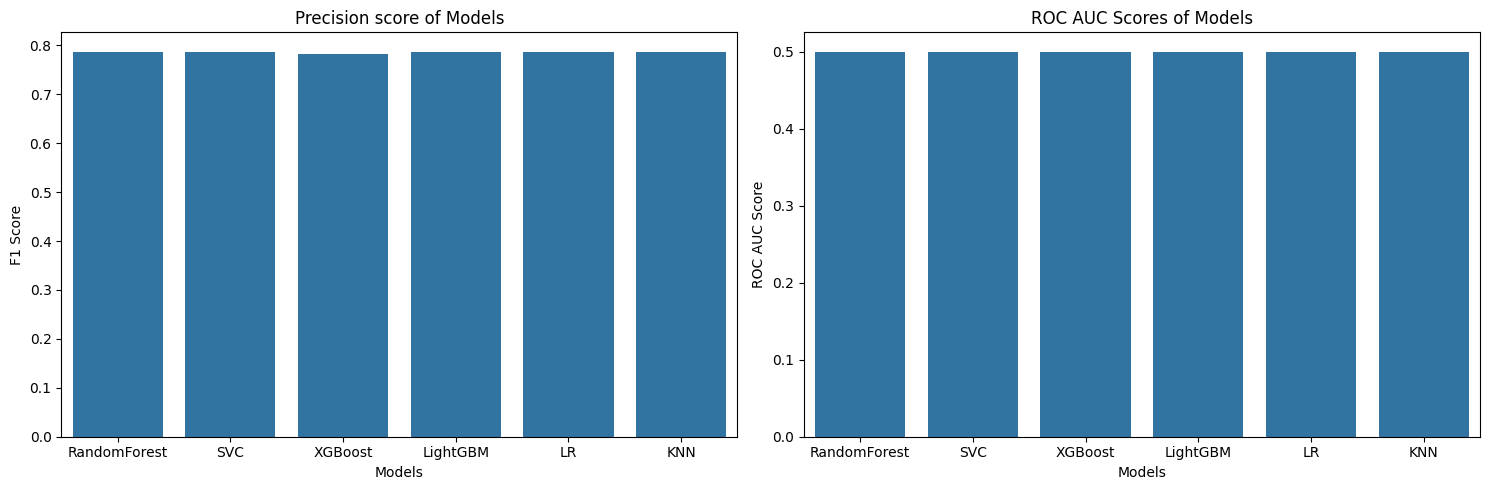

In [21]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

models = {
    'RandomForest' : RandomForestClassifier(),
    'SVC' : SVC(),
    'XGBoost' : XGBClassifier(),
    'LightGBM' : LGBMClassifier(),
    'LR' : LogisticRegression(),
    'KNN' : KNeighborsClassifier(12)
}

pre = []
roc_auc = []
for m in tqdm(models.keys()):
    clf = MultiOutputClassifier(models[m])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    pre.append(accuracy_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred, average='weighted'))




# Plot histogram of f1 and roc auc scores of each model
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot f1 scores
sns.barplot(x=list(models.keys()), y=pre, ax=axes[0])
axes[0].set_title('Precision score of Models')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('F1 Score')

# Plot ROC AUC scores
sns.barplot(x=list(models.keys()), y=roc_auc, ax=axes[1])
axes[1].set_title('ROC AUC Scores of Models')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('ROC AUC Score')

plt.tight_layout()
plt.show()


In [19]:
#clf = RandomForestClassifier(class_weight='balanced', random_state=42)
#clf = XGBClassifier()
clf = SVC(
    #class_weight='balanced',
    kernel='sigmoid'
)
model = MultiOutputClassifier(clf)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=label_columns)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=label_columns))

Accuracy: 0.7872
               precision    recall  f1-score   support

       SR-HSE       0.00      0.00      0.00        12
        NR-AR       0.00      0.00      0.00        14
       SR-ARE       0.00      0.00      0.00        45
 NR-Aromatase       0.00      0.00      0.00        10
    NR-ER-LBD       0.00      0.00      0.00        16
       NR-AhR       0.00      0.00      0.00        27
       SR-MMP       0.00      0.00      0.00        26
        NR-ER       0.00      0.00      0.00        47
NR-PPAR-gamma       0.00      0.00      0.00         6
       SR-p53       0.00      0.00      0.00         5
     SR-ATAD5       0.00      0.00      0.00         1
    NR-AR-LBD       0.00      0.00      0.00         4

    micro avg       0.00      0.00      0.00       213
    macro avg       0.00      0.00      0.00       213
 weighted avg       0.00      0.00      0.00       213
  samples avg       0.00      0.00      0.00       213



C:\Users\vmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

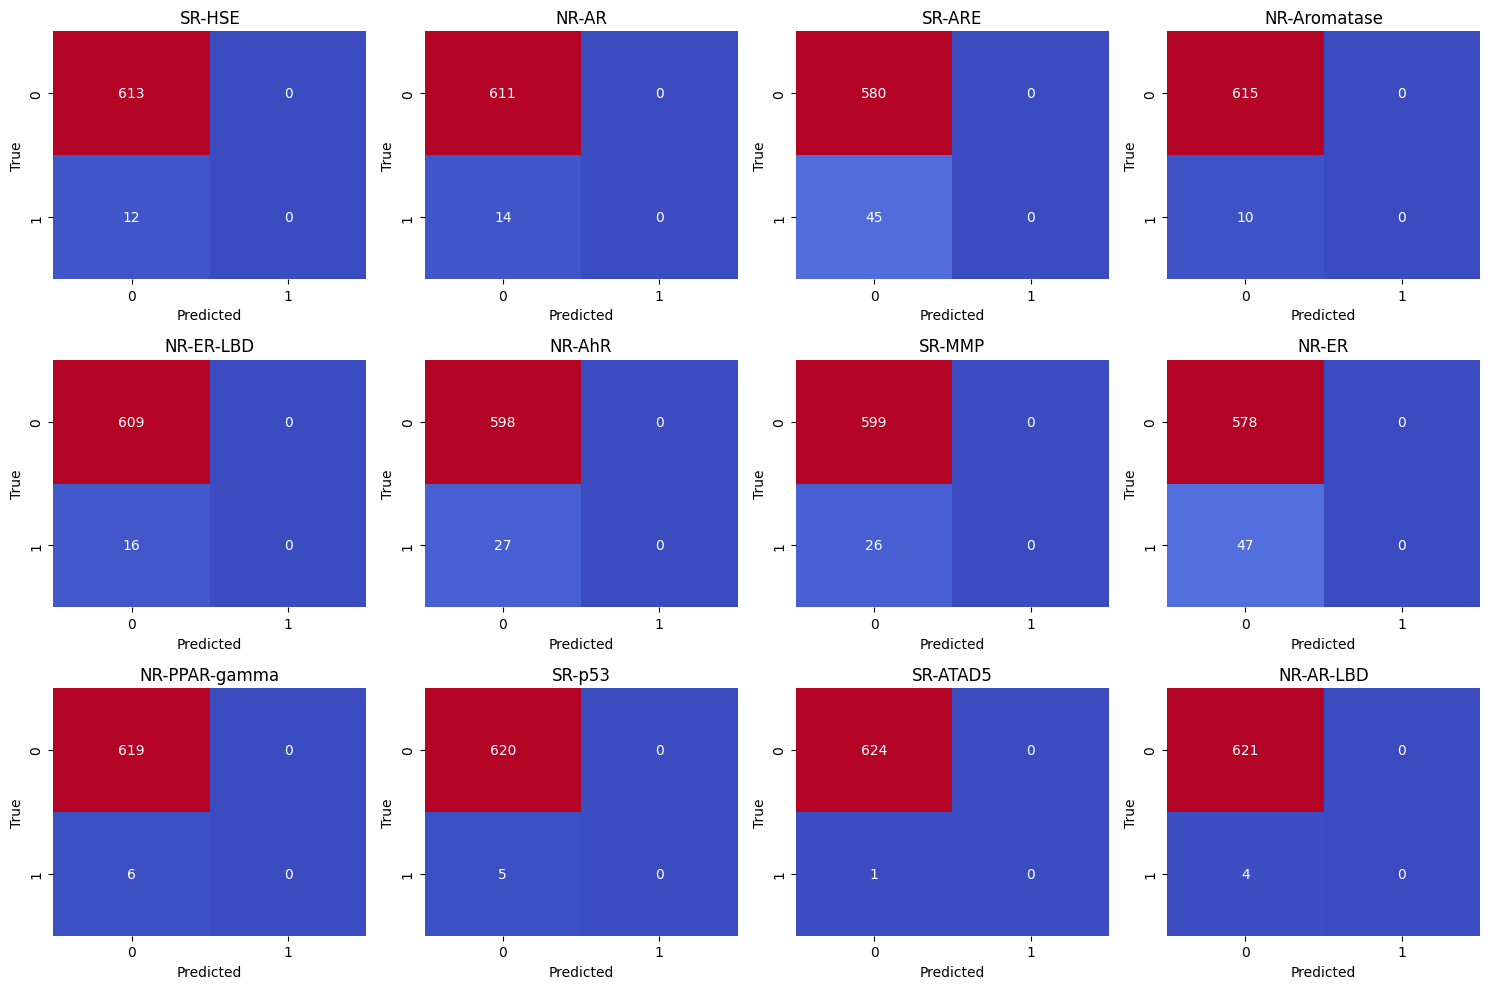

In [15]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

mat = multilabel_confusion_matrix(y_test, y_pred)
mat
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for i, (ax, label) in enumerate(zip(axes, label_columns)):
    sns.heatmap(mat[i], annot=True, fmt='d', ax=ax, cmap='coolwarm', cbar=False)
    ax.set_title(label)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

In [13]:
len(X_train)

2498